## IS453 Financial Analytics
## Week 10 - Credit Scoring Lab Data

### Grouping and Screening

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [26]:
hmeq_data = pd.read_csv('hmeq_data.csv')

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## 1. Fine classing

**Use pd.qcut to divide numeric variables into quantile ranges**

** Split the CLAGE variale data into 20 groups using equal frequency binning using qcut**

**Assign the bins from qcut output to the original dataframe**


In [27]:
# sample code
bin_count = 20
variable = 'CLAGE'

# create a copy to work on
hmeq_data_working = hmeq_data.copy() 

# reduce to just the variable and the target
hmeq_data_working = hmeq_data_working[[variable, 'BAD']]

# create equal frequency bin ranges using qcut
hmeq_data_working['Bin_Range'] = pd.qcut(hmeq_data[variable],q=bin_count, precision=0)

# missing values have been assigned NaN when binning with pd.qcut 
# rename NaN to 'Missing' and create bin range for those
hmeq_data_working['Bin_Range'] = hmeq_data_working['Bin_Range'].astype('object')
hmeq_data_working['Bin_Range'].fillna('Missing', inplace = True)

hmeq_data_working


,CLAGE,BAD,Bin_Range
0,94.366667,1,"(85.0, 95.0]"
1,121.833333,1,"(115.0, 123.0]"
2,149.466667,1,"(145.0, 160.0]"
3,NaN,1,Missing
4,93.333333,0,"(85.0, 95.0]"
...,...,...,...
5955,221.808718,0,"(216.0, 232.0]"
5956,208.692070,0,"(204.0, 216.0]"
5957,212.279697,0,"(204.0, 216.0]"
5958,213.892709,0,"(204.0, 216.0]"


In [28]:
# check the counts in each bin, should be about the same
hmeq_data_working.groupby('Bin_Range').count()

,CLAGE,BAD
Bin_Range,,
"(-1.0, 69.0]",283,283
"(69.0, 85.0]",283,283
"(85.0, 95.0]",282,282
"(95.0, 106.0]",283,283
"(106.0, 115.0]",282,282
"(115.0, 123.0]",283,283
"(123.0, 132.0]",282,282
"(132.0, 145.0]",283,283
"(145.0, 160.0]",283,283


In [29]:
# check the number of bads in each bin
hmeq_data_working.groupby('Bin_Range').sum().loc[:, 'BAD']

Bin_Range
(-1.0, 69.0]       114
(69.0, 85.0]        81
(85.0, 95.0]        75
(95.0, 106.0]       71
(106.0, 115.0]      65
(115.0, 123.0]      82
(123.0, 132.0]      62
(132.0, 145.0]      76
(145.0, 160.0]      66
(160.0, 173.0]      58
(173.0, 182.0]      39
(182.0, 193.0]      44
(193.0, 204.0]      41
(204.0, 216.0]      44
(216.0, 232.0]      44
(232.0, 247.0]      33
(247.0, 268.0]      31
(268.0, 296.0]      25
(296.0, 322.0]      30
(322.0, 1168.0]     30
Missing             78
Name: BAD, dtype: int64

## 2. Calculate WOE and IV for classed variable

**Calculate the number of events and non-events in each bin (default vs non-default)**

We are going to create a binning table.

Create a new dataframe with these columns:

1. Bin_Range

2. Count = total number of people that belong to this bin

3. Events = number of people that defaulted in this bin

4. Non_Events = number of that people that paid off the loan in this bin

5. %_of_Events

6. %_of_Non_Events

7. WOE

8. IV




In [30]:
# sample code 

# create new dataframe for variable WOE and IV calcs
variable_data = pd.DataFrame()

# create initial column with bin ranges
variable_data['Bin_Range'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

variable_data

,Bin_Range
0,"(-1.0, 69.0]"
1,"(69.0, 85.0]"
2,"(85.0, 95.0]"
3,"(95.0, 106.0]"
4,"(106.0, 115.0]"
5,"(115.0, 123.0]"
6,"(123.0, 132.0]"
7,"(132.0, 145.0]"
8,"(145.0, 160.0]"
9,"(160.0, 173.0]"


In [31]:
# sample code 

# add count, num events, and num non-events
variable_data['Count'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).count()['BAD']

variable_data['Events'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).sum()['BAD']

variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

variable_data

,Bin_Range,Count,Events,Non_Events
0,"(-1.0, 69.0]",283,114,169
1,"(69.0, 85.0]",283,81,202
2,"(85.0, 95.0]",282,75,207
3,"(95.0, 106.0]",283,71,212
4,"(106.0, 115.0]",282,65,217
5,"(115.0, 123.0]",283,82,201
6,"(123.0, 132.0]",282,62,220
7,"(132.0, 145.0]",283,76,207
8,"(145.0, 160.0]",283,66,217
9,"(160.0, 173.0]",283,58,225


In [32]:
# sample code 

# add columns with WOE calculations
variable_data['%_of_Events'] = variable_data['Events'] / sum(variable_data['Events'])

variable_data['%_of_Non_Events'] = variable_data['Non_Events'] / sum(variable_data['Non_Events'])

variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']

variable_data

,Bin_Range,Count,Events,Non_Events,%_of_Events,%_of_Non_Events,WOE,IV
0,"(-1.0, 69.0]",283,114,169,0.095879,0.035422,-0.995743,0.060199
1,"(69.0, 85.0]",283,81,202,0.068124,0.042339,-0.475625,0.012264
2,"(85.0, 95.0]",282,75,207,0.063078,0.043387,-0.374213,0.007369
3,"(95.0, 106.0]",283,71,212,0.059714,0.044435,-0.295537,0.004515
4,"(106.0, 115.0]",282,65,217,0.054668,0.045483,-0.183933,0.001689
5,"(115.0, 123.0]",283,82,201,0.068966,0.042130,-0.492858,0.013226
6,"(123.0, 132.0]",282,62,220,0.052145,0.046112,-0.122950,0.000742
7,"(132.0, 145.0]",283,76,207,0.063919,0.043387,-0.387458,0.007955
8,"(145.0, 160.0]",283,66,217,0.055509,0.045483,-0.199201,0.001997
9,"(160.0, 173.0]",283,58,225,0.048780,0.047160,-0.033786,0.000055


**Encapsulate the code in a function so it can be rerun**

In [33]:
# sample code

def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['BAD']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['BAD']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)

# test the function
woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=20)
print(f"IV for CLAGE = {woe_iv(woe_bin_data, 'CLAGE')[0]:.4f}")
woe_iv(woe_bin_data, 'CLAGE')

IV for CLAGE = 0.2478


(0.24777715351807875,
               Bin_Range  Count  Events  Non_Events  %_of_Events  \
 0      (-0.001, 68.913]    283     114         169     0.095879   
 1      (68.913, 84.554]    283      81         202     0.068124   
 2      (84.554, 95.367]    282      75         207     0.063078   
 3     (95.367, 105.769]    283      71         212     0.059714   
 4    (105.769, 115.117]    282      65         217     0.054668   
 5    (115.117, 122.821]    283      82         201     0.068966   
 6    (122.821, 132.152]    282      62         220     0.052145   
 7    (132.152, 145.101]    283      76         207     0.063919   
 8    (145.101, 160.333]    283      66         217     0.055509   
 9    (160.333, 173.467]    283      58         225     0.048780   
 10   (173.467, 182.356]    282      39         243     0.032801   
 11   (182.356, 193.104]    282      44         238     0.037006   
 12   (193.104, 204.035]    283      41         242     0.034483   
 13   (204.035, 215.709]  

**Ex Q1. Compute Information Value for the CLAGE characteristic**

What is the IV, rounded to 4 decimal places, using 20 bins? 

Run again with the number of bins set to 10 and recalculate the IV. Which is higher? 

Why do you think that is the case?

In [34]:
# your code here

woe_bin_data2 = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data2['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=10)
print(f"IV for CLAGE = {woe_iv(woe_bin_data2, 'CLAGE')[0]:.4f}")
woe_iv(woe_bin_data2, 'CLAGE')


IV for CLAGE = 0.2306


(0.23064099109529362,
               Bin_Range  Count  Events  Non_Events  %_of_Events  \
 0      (-0.001, 84.554]    566     195         371     0.164003   
 1     (84.554, 105.769]    565     146         419     0.122792   
 2    (105.769, 122.821]    565     147         418     0.123633   
 3    (122.821, 145.101]    565     138         427     0.116064   
 4    (145.101, 173.467]    566     124         442     0.104289   
 5    (173.467, 193.104]    564      83         481     0.069807   
 6    (193.104, 215.709]    565      85         480     0.071489   
 7    (215.709, 247.087]    565      77         488     0.064760   
 8    (247.087, 295.716]    565      56         509     0.047098   
 9   (295.716, 1168.234]    566      60         506     0.050463   
 10              Missing    308      78         230     0.065601   
 
     %_of_Non_Events       WOE        IV  
 0          0.077761 -0.746241  0.064357  
 1          0.087822 -0.335179  0.011721  
 2          0.087613 -0.344394 

Your answer here

20 bins - IV for CLAGE = 0.2478

10 bins - IV for CLAGE = 0.2306

20 bins has more granularity which allows for better differentiation generally

**Plot the WOE and the bin counts** 

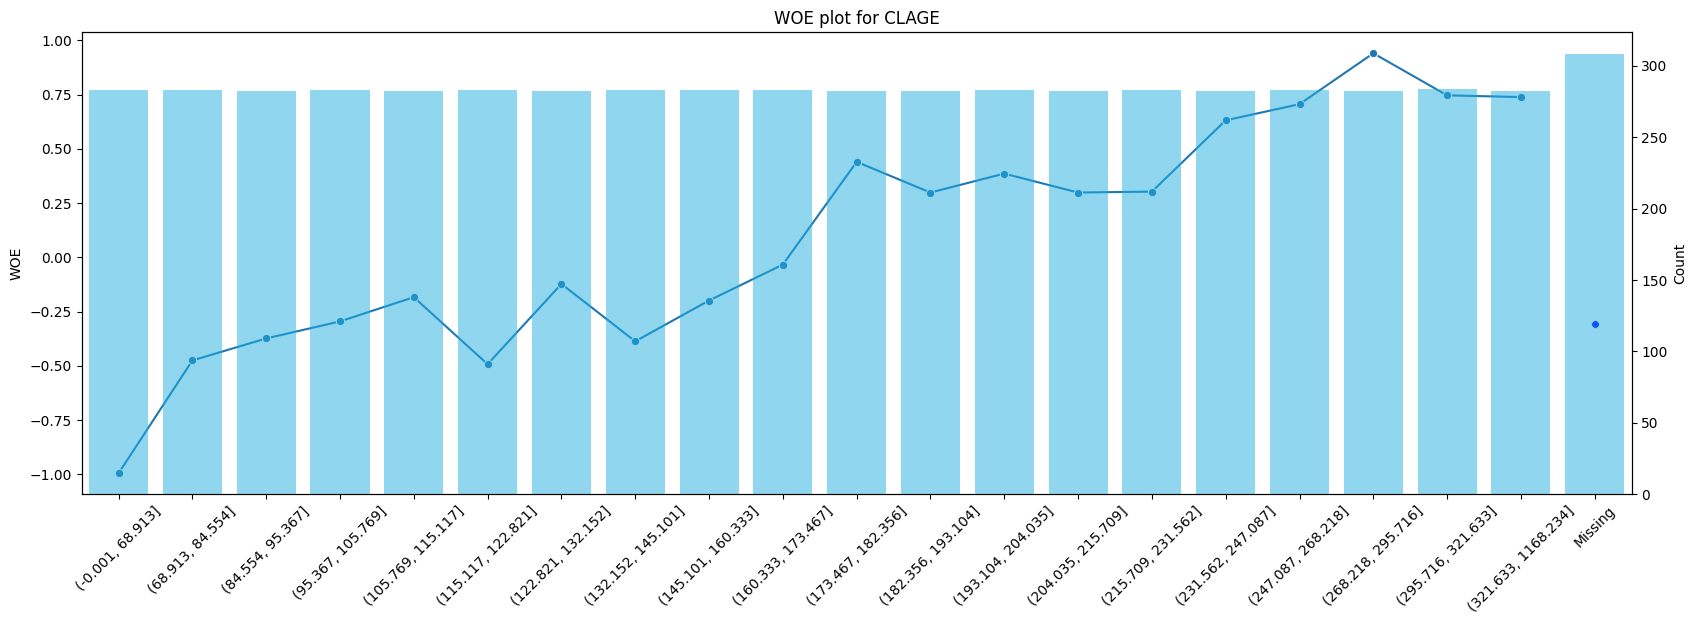

In [35]:
# sample code
variable = 'CLAGE'

woe_bin_data = hmeq_data.loc[:,(variable, 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data[variable],q=20)
variable_data = woe_iv(woe_bin_data, variable)[1]

# set up plots
ffig, ax1 = plt.subplots(figsize=(20,6))

sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
plt.xticks(rotation=45)

# Create the scatter plot to plot the Missing WOE data point
last_point = len(variable_data['WOE']) - 1
scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)

ax2 = ax1.twinx()

# plot the bin counts
sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')

plt.title("WOE plot for " + variable)
plt.show()

**Create function to calculate WOE, IV and plot IV**

Combine the code above into a parameterised function that you can use going forward to print IV rounded to 4 decimal places and plot WOE.

IV for CLAGE with 21 bins: 0.2478


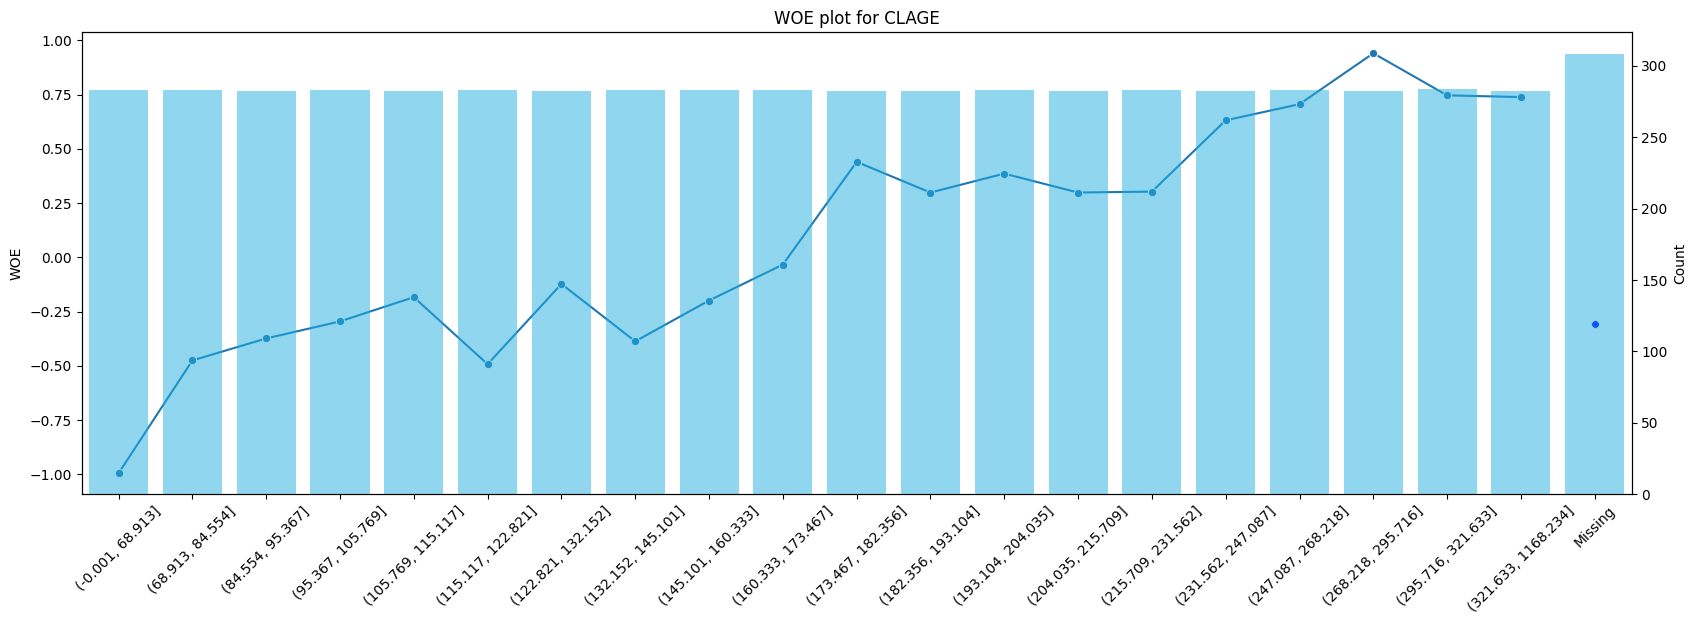

In [36]:
# sample code

# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()
    
# test the function
woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=20)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data, 'CLAGE')

## 3. Variable screening

**Ex Q2. Calculate the IV for the large value variables: LOAN, MORTDUE, CLAGE, DEBTINC using bin_count = 20**

What are their IVs and corresponding predictive strength?  

Which variables(s) can be dropped on that basis?

*Hint: refer to the interpretation table for IV in the lecture slides*

In [37]:
# your code here

large_val_numeric = ['LOAN', 'MORTDUE', 'CLAGE', 'DEBTINC']
# add code to obtain IV for each of the variables

for variable in large_val_numeric:
    woe_bin_data3 = hmeq_data.loc[:,(variable, 'BAD')]
    woe_bin_data3['Bin_Range'] = pd.qcut(hmeq_data[variable],q=20)
    print(f"IV for {variable} = {woe_iv(woe_bin_data3, variable)[0]:.4f}")
    woe_iv(woe_bin_data3, variable)

IV for LOAN = 0.2270
IV for MORTDUE = 0.0734
IV for CLAGE = 0.2478
IV for DEBTINC = 1.9990


Your answer

IV for LOAN = 0.2270 (medium predictive strength)

IV for MORTDUE = 0.0734 (weak predictive strength)

IV for CLAGE = 0.2478 (medium predictive strength)

IV for DEBTINC = 1.9990 (overly predictive)

MORTDUE and DEBTINC can be dropped

## 4. Coarse classing

Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE


IV for CLAGE with 8 bins: 0.2323


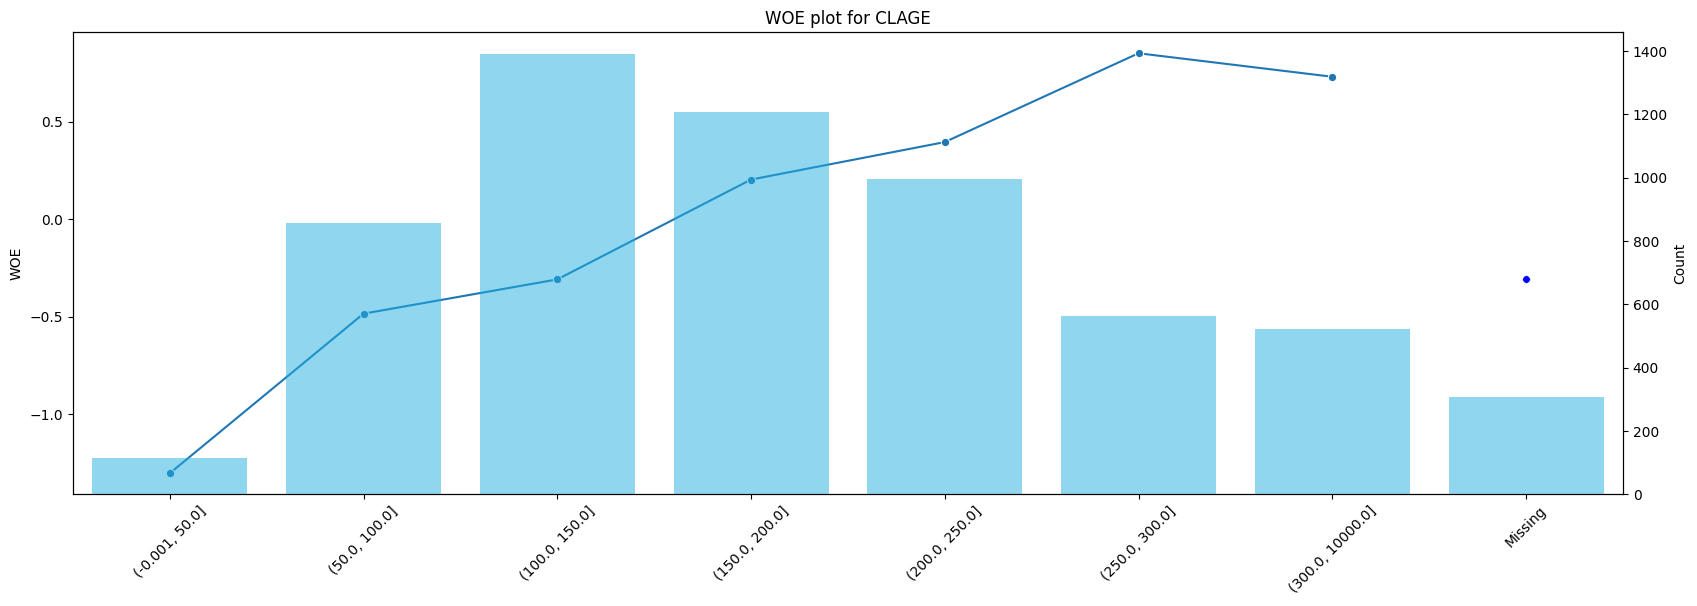

In [38]:
# sample code

bin_edges = [0, 50, 100, 150, 200, 250, 300, 10000]
variable = 'CLAGE'

# create groupings based on specified bin edges
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()

woe_iv_plot(hmeq_data_working, variable)


In [39]:
hmeq_data_working[['Bin_Range']].isin(['Missing']).sum()


Bin_Range    0
dtype: int64

**Ex Q3. Adjust the bin ranges so WOE is monotonic**

What are three issues with the WOE chart based on the default fixed interval binning approach used?

Reduce the number of bins to 5, including the 'Missing' bin, using pd.cut to address these issues.

How did the the IV change for your new binning arrangement?  Is it still in the same predictive range?

Based on its WOE value, which bin could 'Missing' be potentially combined with?

*Hint: Look at the WOE chart based on equal bins and look for groups that are at similar ranges and define the bin edges according to those groups.*

IV for CLAGE with 5 bins: 0.2255


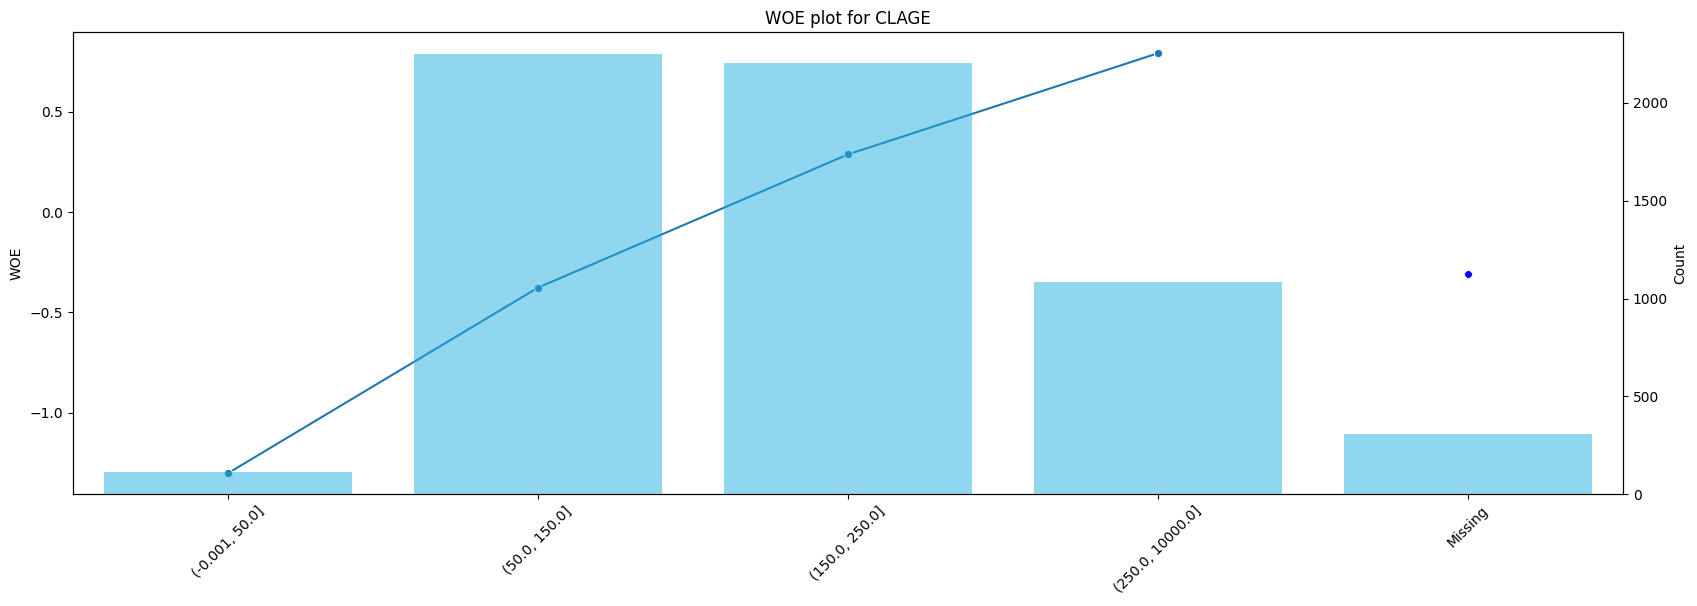

In [40]:
# your code here
#issues are monotonicity, 
bin_edges = [0, 50, 150, 250, 10000]
variable = 'CLAGE'

# create groupings based on specified bin edges
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()

woe_iv_plot(hmeq_data_working, variable)



Your answer

1) It is not monotonic
2) IV decreased to 0.2255 but is still in the same predictive range
3) missing could potentially combine with (50,150] since they are pretty similar in terms of WOE

# DYI

**DIY Q1:**

Review the LOAN variable WOE and IV with fine classing.  Is the trend start-to-end generally monotonic or is just part of it monotonic?

Adjust the bin edges so that you have three bins for the numeric range and the WOE is monotonic for the portion that appears to have a clear trend. Define a fourth bin for the part of the range that does not fit the trend.

How did the the IV change for your new binning arrangement?  Is it still in the same predictive range?

In [41]:
# your code here
woe_bin_data4 = hmeq_data.loc[:,('LOAN', 'BAD')]
woe_bin_data4['Bin_Range'] = pd.qcut(hmeq_data['LOAN'],q=20)
print(f"IV for LOAN = {woe_iv(woe_bin_data4, 'LOAN')[0]:.4f}")
woe_iv(woe_bin_data4, 'LOAN')

IV for LOAN = 0.2270


(0.22698573260515517,
              Bin_Range  Count  Events  Non_Events  %_of_Events  \
 0   (1099.999, 5900.0]    304     142         162     0.119428   
 1     (5900.0, 7600.0]    299      87         212     0.073171   
 2     (7600.0, 8900.0]    298      56         242     0.047098   
 3    (8900.0, 10000.0]    310      81         229     0.068124   
 4   (10000.0, 11100.0]    305      50         255     0.042052   
 5   (11100.0, 12100.0]    277      56         221     0.047098   
 6   (12100.0, 13100.0]    294      57         237     0.047939   
 7   (13100.0, 14400.0]    316      50         266     0.042052   
 8   (14400.0, 15300.0]    308      86         222     0.072330   
 9   (15300.0, 16300.0]    270      45         225     0.037847   
 10  (16300.0, 17500.0]    316      50         266     0.042052   
 11  (17500.0, 18800.0]    288      34         254     0.028595   
 12  (18800.0, 20300.0]    302      65         237     0.054668   
 13  (20300.0, 21700.0]    289      34  

IV for LOAN with 20 bins: 0.227


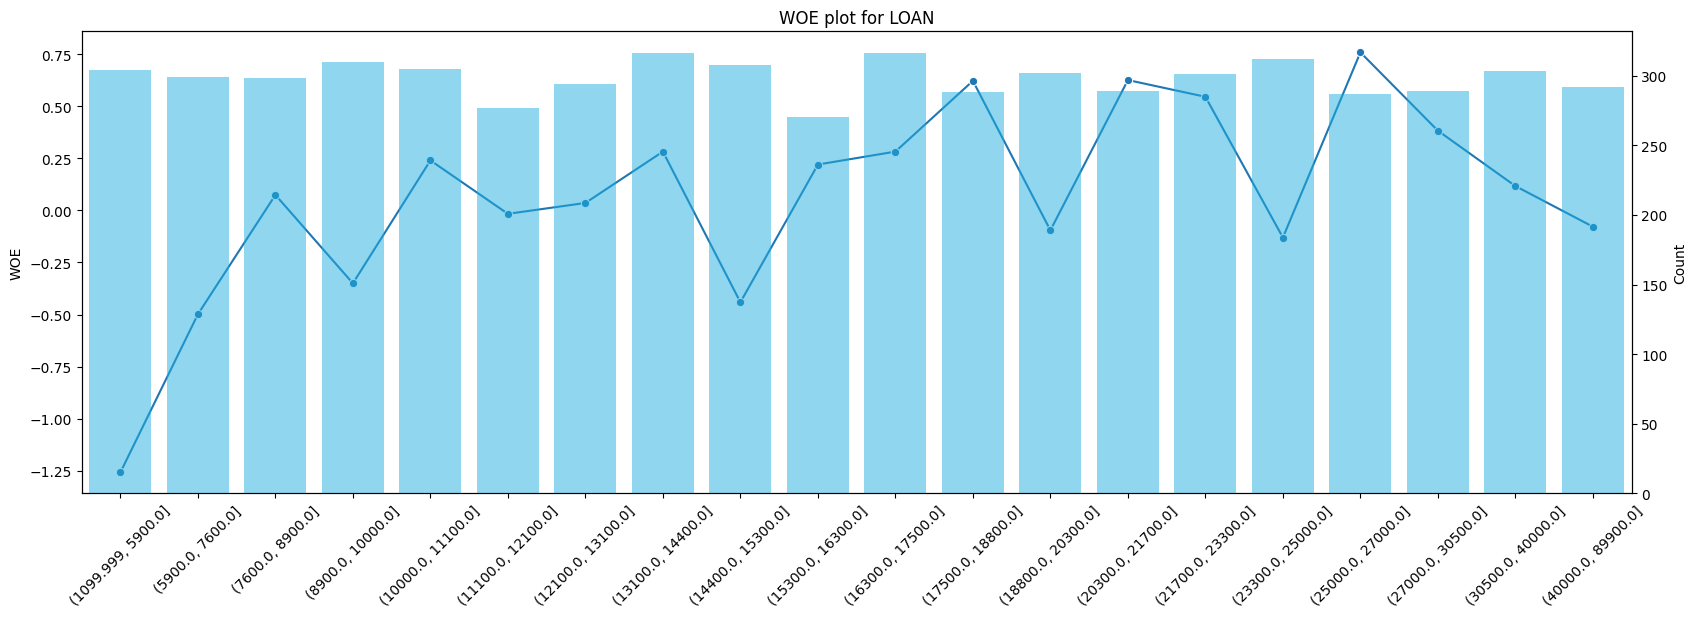

In [42]:
woe_bin_data4['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data4, 'LOAN')

IV for LOAN with 4 bins: 0.1089


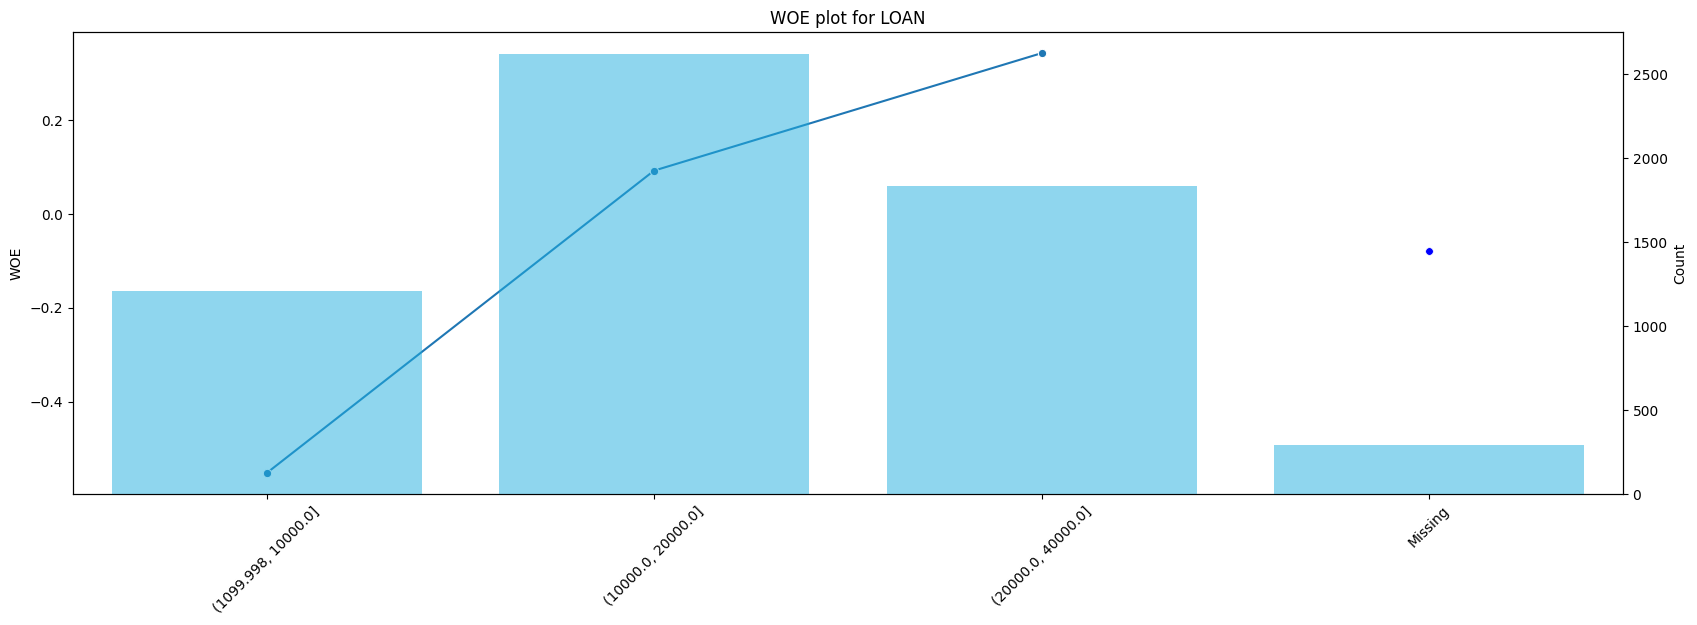

In [43]:
# got to adjust the bins
bin_edges = [1099.999, 10000.0, 20000.0, 40000.0]  
variable = 'LOAN'

# create groupings based on specified bin edges
woe_bin_data4['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
woe_bin_data4['Bin_Range'].value_counts().sort_index()

woe_iv_plot(woe_bin_data4, variable)

Your answer

- only part of it is monotonic
- missing could potentially combine with (10000, 20000]
- IV decreased significantly from 0.2270 to 0.1089 but still in the same range of medium predictive power but is just at the boundary


**DIY Q2:**

Review the DEBTINC variable WOE and IV based on fine classing.  

Is the trend start to end generally monotonic or just part of it?

Adjust the bin edges so that you have three bins for the numeric range and the WOE is monotonic for the portion that appears to have a clear trend. Define a fourth bin for the part of the range that does not fit the trend.

How did the the IV change for your new binning arrangement? Is it still in the same predictive range?

In [55]:
# your code here
woe_bin_data5 = hmeq_data.loc[:,('DEBTINC', 'BAD')]
woe_bin_data5['Bin_Range'] = pd.qcut(hmeq_data['DEBTINC'],q=20)
print(f"IV for DEBTINC = {woe_iv(woe_bin_data5, 'DEBTINC')[0]:.4f}")
woe_iv(woe_bin_data5, 'DEBTINC')

IV for DEBTINC = 1.9990


(1.9990272250258383,
             Bin_Range  Count  Events  Non_Events  %_of_Events  \
 0     (0.523, 20.512]    235      22         213     0.018503   
 1    (20.512, 23.778]    235      13         222     0.010934   
 2    (23.778, 25.781]    234      12         222     0.010093   
 3    (25.781, 27.616]    235       8         227     0.006728   
 4     (27.616, 29.14]    235      10         225     0.008410   
 5     (29.14, 30.313]    234      10         224     0.008410   
 6    (30.313, 31.554]    235      16         219     0.013457   
 7    (31.554, 32.855]    234      15         219     0.012616   
 8    (32.855, 33.925]    235      14         221     0.011775   
 9    (33.925, 34.818]    235      14         221     0.011775   
 10   (34.818, 35.771]    234      20         214     0.016821   
 11   (35.771, 36.589]    235      18         217     0.015139   
 12   (36.589, 37.445]    234      20         214     0.016821   
 13   (37.445, 38.222]    235      14         221     0

IV for DEBTINC with 21 bins: 1.999


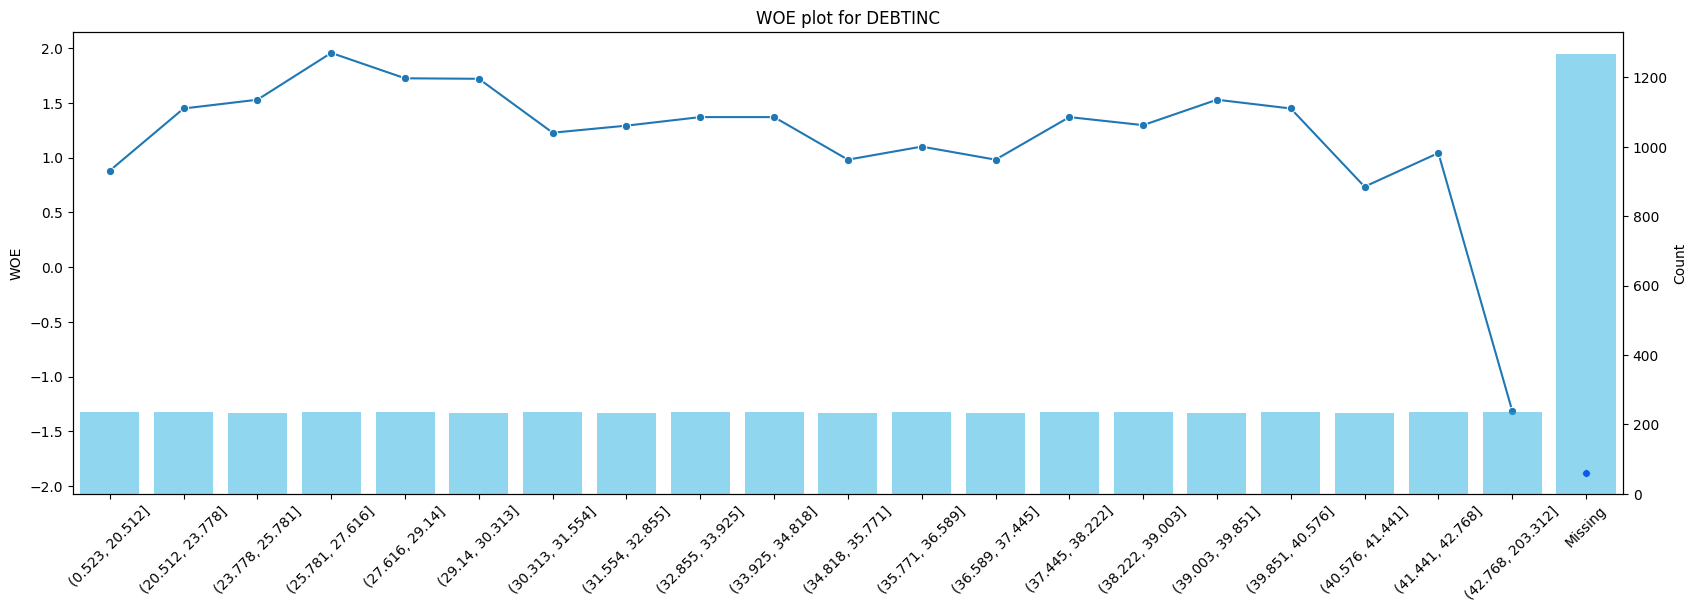

In [56]:
woe_bin_data5 = hmeq_data.loc[:,('DEBTINC', 'BAD')]
woe_bin_data5['Bin_Range'] = pd.qcut(hmeq_data['DEBTINC'], q=20)
woe_bin_data5['Bin_Range'] = woe_bin_data5['Bin_Range'].astype('object')
woe_bin_data5['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data5, 'DEBTINC')

IV for DEBTINC with 5 bins: 1.9669


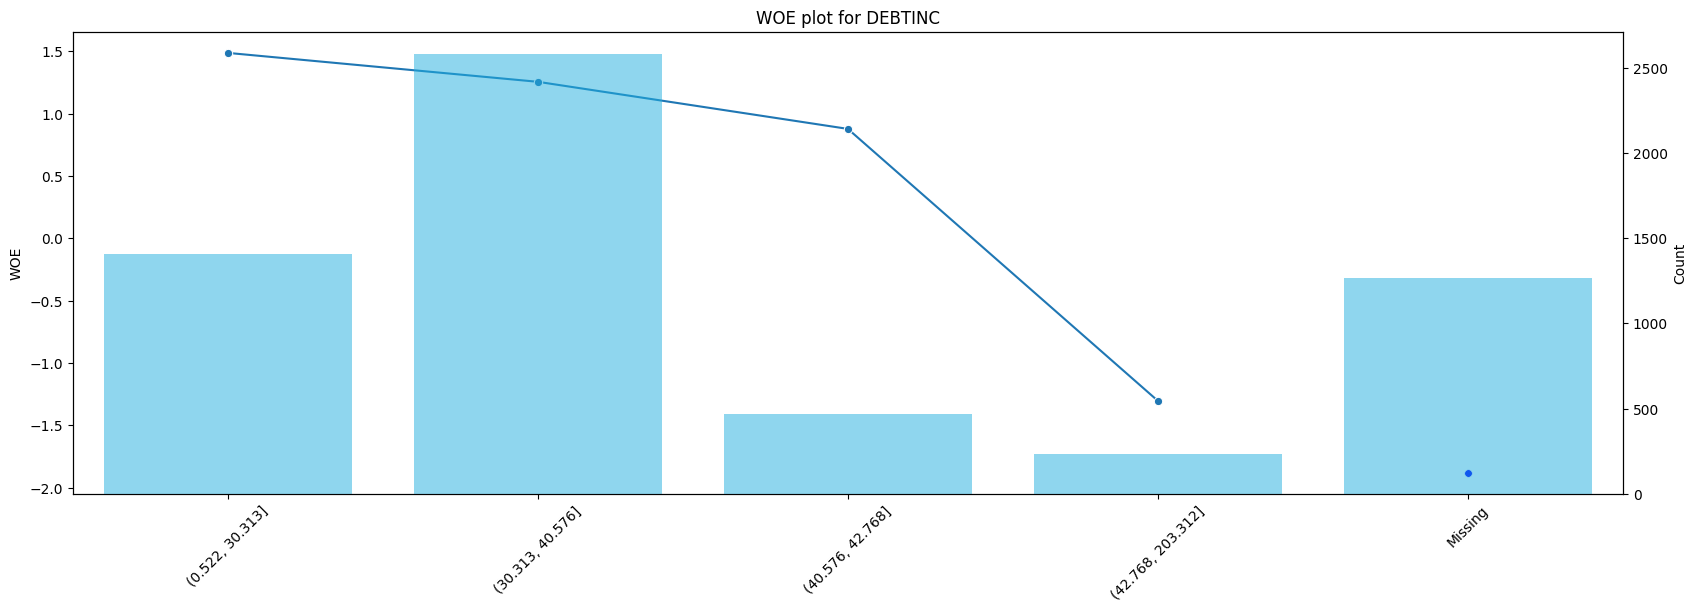

In [63]:
bin_edges = [0.523, 30.313, 40.576, 42.768, 203.312]  
variable = 'DEBTINC'

# create groupings based on specified bin edges
woe_bin_data5['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
woe_bin_data5['Bin_Range'].value_counts().sort_index()

woe_iv_plot(woe_bin_data5, variable)

Your answer

- part of it is monotonic
- the fourth bin would be (42, 203)
- IV decreased from 1.999 to 1.9669 - still in the same medium predictive range

**DIY Q3:**

Review the DEROG variable WOE and IV based on fine classing.  

Redefine groupings to just have two, one with negative WOE and another with positive WOE

What are bin edges?

How did the the IV change for your new binning arrangement? Is it still in the same predictive range?

Which group is the 'Missing' bin WOE the closest match to?

IV for DEROG with 5 bins: 0.2075


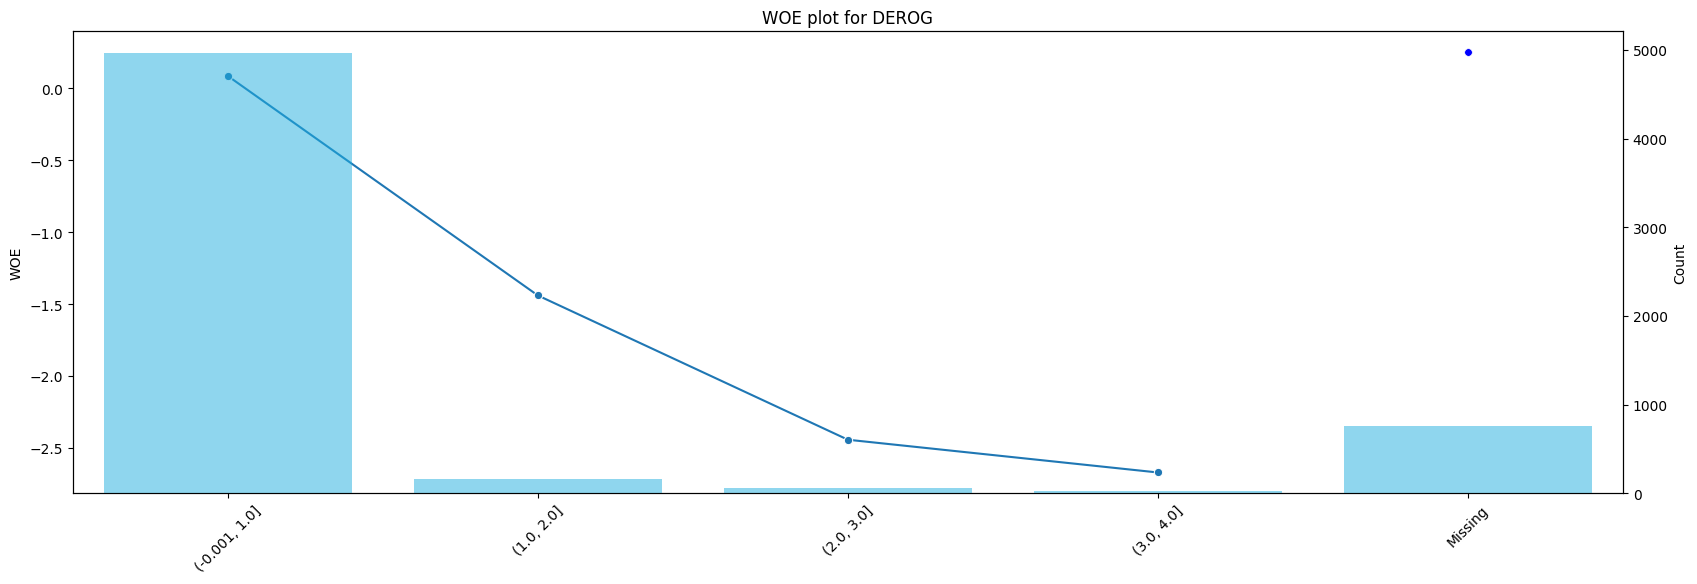

In [45]:
# sample code

bin_edges = [0, 1, 2, 3, 4]
variable = 'DEROG'

# create groupings based on specified bin edges
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()
woe_iv_plot(hmeq_data_working, variable)

IV for DEROG with 3 bins: 0.2798


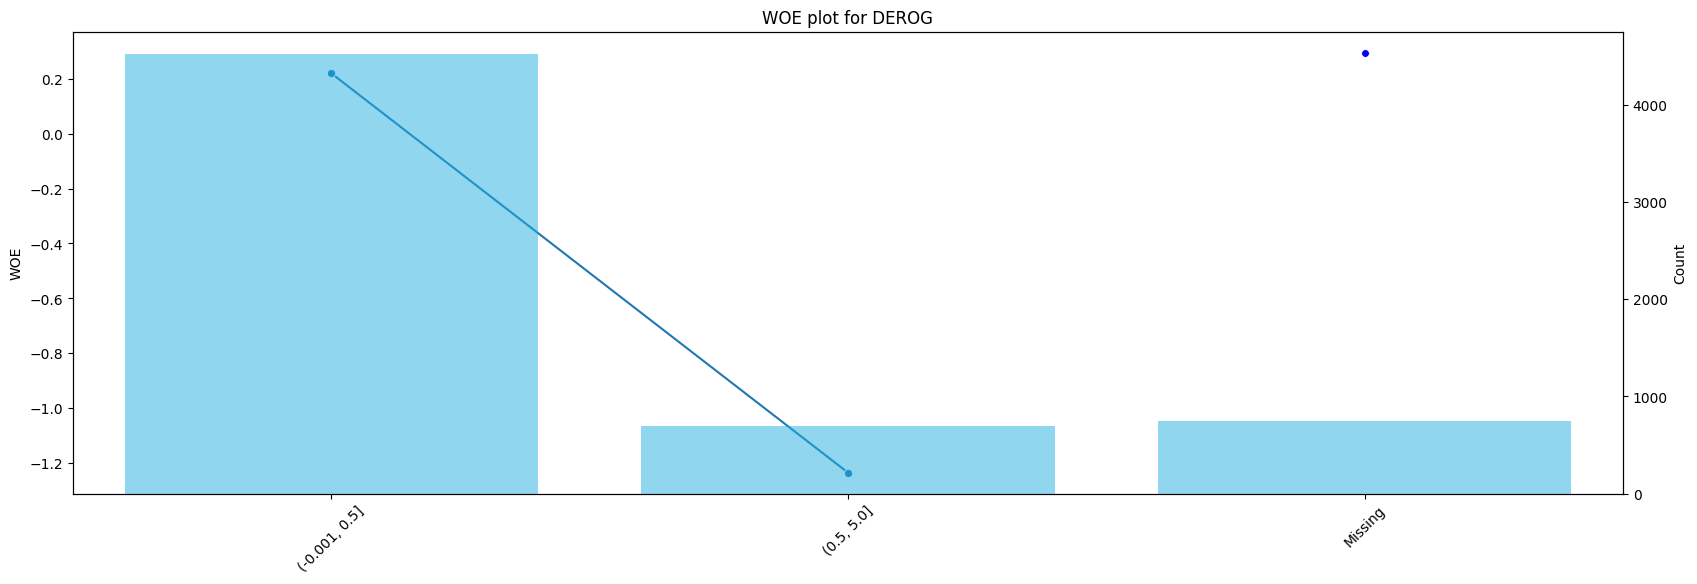

In [64]:
# your code here
bin_edges = [0, 0.5, 5]
variable = 'DEROG'
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data['DEROG'], bins = bin_edges, include_lowest=True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()

woe_iv_plot(hmeq_data_working, variable)

Your answer

- IV increased from 0.2075 0.2798 - medium predictive strength
- missing closest to (-0.001, 0.5]

# Group Assignment Preparation

**Use scorecardpy to do automatic bin assignment and charting**

Use the scorecardpy package to automate coarse classing and to calculate WOE and IV 

In [ ]:
# sample code

# install the scorecardpy package
# make sure you are running Python 3.9 or later

# make sure there these packages are installed
# !pip install pandas==2.1.1
# !pip install scorecardpy==0.1.9.7

# after downloading, restart your kernel

# if you get errors with the scorecardpy plot functions try
# !pip install numpy==1.23.5
# !pip install pandas==1.4.4

  Obtaining dependency information for pandas==2.1.1 from https://files.pythonhosted.org/packages/af/7b/d170f9c8306c7673f57ca4f442e326d36e20299725edc5d0af36a3e3b041/pandas-2.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 35.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
classiq 0.36.1 requires pandas<2.0.0,>=1.4.0, but you have pandas 2.1.1 which is incompatible.
datasets 2.12.0 requires dill<0.3.7,>=0.3.0, but you have dill 0.3.8 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=score

In [66]:
# sample code

import scorecardpy as sc

# make another copy of the original data
hmeq_data_working = hmeq_data.copy() 

# reduce the data frame to just just the dependent and to independent variables
hmeq_data_woe = hmeq_data_working.loc[:,['BAD','DEBTINC','JOB']]

# automatically calculate bin ranges, WOE, and IV for the independent variables
bins = sc.woebin(hmeq_data_woe, y='BAD')

# scorecardpy calcualtes WoE as the opposite of the normal formula, so we will fix
for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1


# print the bin details
for variable, bindetails in bins.items():
    print(variable , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...
DEBTINC  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBTINC,missing,1267,0.212584,481,786,0.620363,-1.880533,1.053554,1.888705,missing,True
1,DEBTINC,"[-inf,31.0)",1534,0.257383,1454,80,0.052151,1.510604,0.358730,1.888705,31.0,False
2,DEBTINC,"[31.0,42.0)",2804,0.470470,2602,202,0.072040,1.166325,0.437941,1.888705,42.0,False
3,DEBTINC,"[42.0,inf)",355,0.059564,234,121,0.340845,-0.729913,0.038481,1.888705,inf,False


----------------------------------------------------------------------------------------------------
JOB  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,JOB,missing,279,0.046812,256,23,0.082437,1.020240,0.035008,0.123026,missing,True
1,JOB,Office,948,0.159060,823,125,0.131857,0.495199,0.033362,0.123026,Office,False
2,JOB,ProfExe,1276,0.214094,1064,212,0.166144,0.223761,0.010005,0.123026,ProfExe,False
3,JOB,"Other%,%Mgr",3155,0.529362,2422,733,0.232330,-0.194240,0.021140,0.123026,"Other%,%Mgr",False
4,JOB,"Self%,%Sales",302,0.050671,206,96,0.317881,-0.625915,0.023511,0.123026,"Self%,%Sales",False


----------------------------------------------------------------------------------------------------


Extract the IV for each of the variables

In [67]:
# sample code

print("IV of the variables:")
for variables , bindetails in bins.items():
    print(variables, round(bindetails['total_iv'][0],3))

IV of the variables:
DEBTINC 1.889
JOB 0.123


Plot the WoE for of the classed variables

In [68]:
# create a function to plot the WoE for the bins and the sample counts
def woe_plot(variable_data, variable_name):
    ffig, ax1 = plt.subplots(figsize=(20,6))
    
    sns.lineplot(data = variable_data['woe'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['bin'] , y = variable_data['count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()

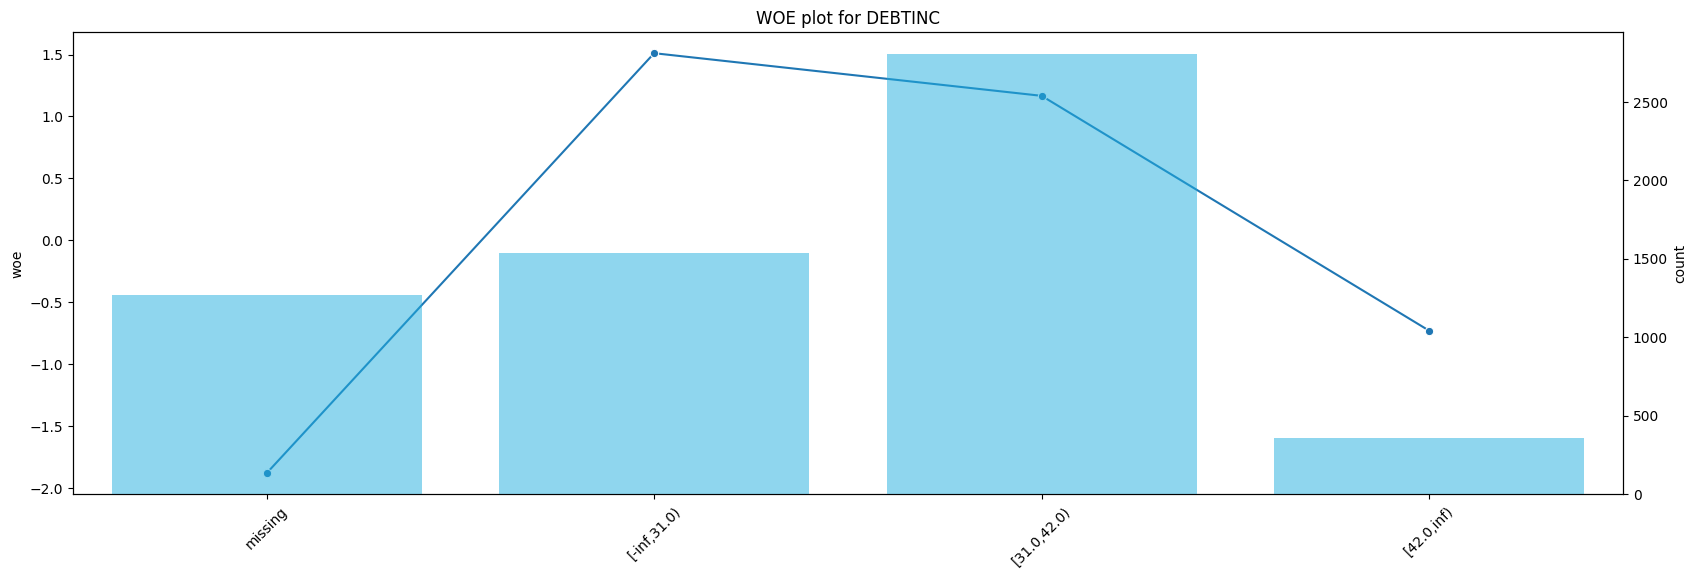

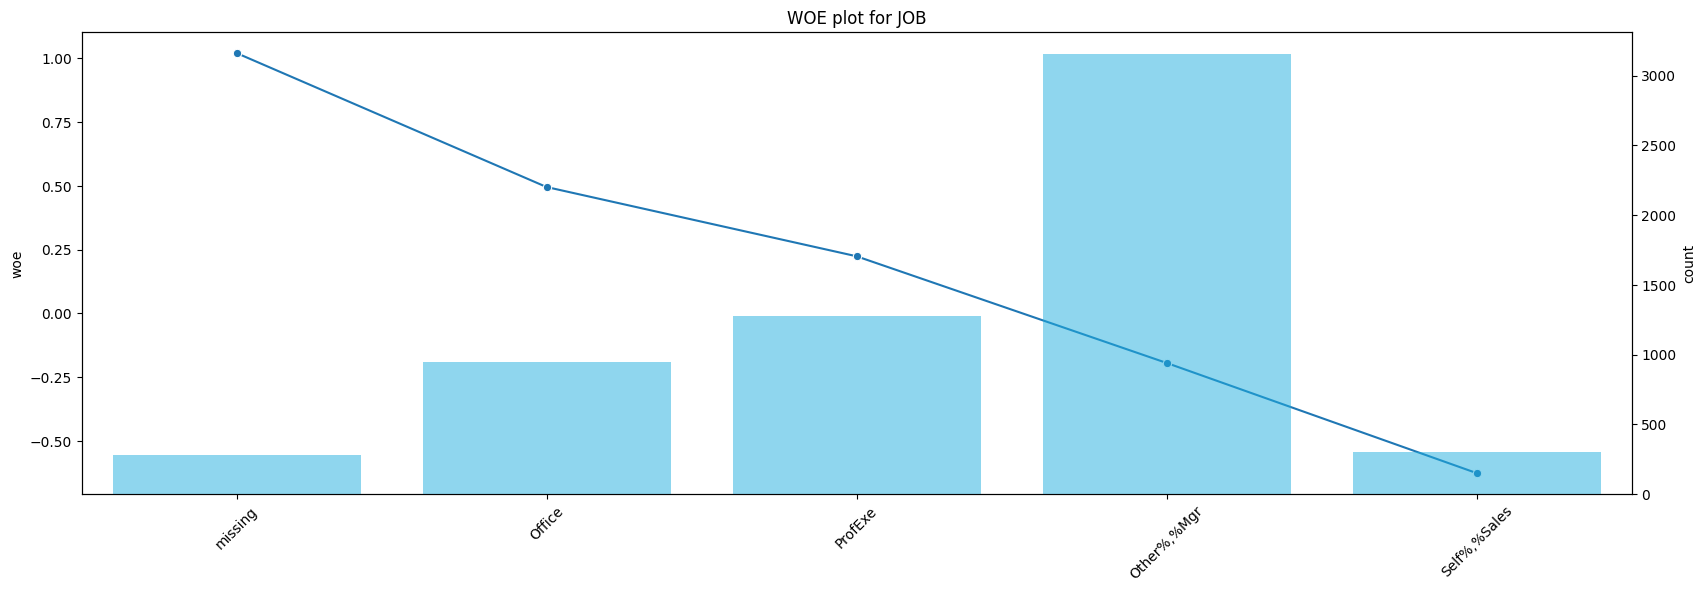

In [69]:
# plot the WOE values

woe_plot(bins['DEBTINC'],'DEBTINC')
woe_plot(bins['JOB'],'JOB')

Overide scorecardpy's binning to define custom bin ranges 

In [70]:
# sample code

breaks_adj = {'DEBTINC' : [0,30,90,120,150,100000]}
bins2 = sc.woebin(hmeq_data_woe, y='BAD', breaks_list=breaks_adj)
bins2['DEBTINC']

[INFO] creating woe binning ...


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBTINC,missing,1267.0,NaN,481.0,786.0,0.620363,NaN,NaN,0.0,missing,True
1,DEBTINC,"[-inf,30.0)",1348.0,NaN,1276.0,72.0,0.053412,NaN,NaN,0.0,30.0,False
2,DEBTINC,"[30.0,90.0)",3339.0,NaN,3014.0,325.0,0.097335,NaN,NaN,0.0,90.0,False
3,DEBTINC,"[90.0,120.0)",2.0,NaN,0.0,2.0,1.000000,NaN,NaN,0.0,120.0,False
4,DEBTINC,"[120.0,150.0)",3.0,NaN,0.0,3.0,1.000000,NaN,NaN,0.0,150.0,False
5,DEBTINC,"[150.0,100000.0)",1.0,NaN,0.0,1.0,1.000000,NaN,NaN,0.0,100000.0,False
6,DEBTINC,"[100000.0,inf)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,inf,False


**DYI Q4: Use scorecardpy to do automatic bin assignment and charting**


Use scoercard py to calculate the WoE and IV for all of the variables in the home equity load dataset

In [71]:
# your code here
hmeq_data_working = hmeq_data.copy() 

# reduce the data frame to just just the dependent and to independent variables
hmeq_data_woe = hmeq_data_working.loc[:,['BAD','DEBTINC','JOB', 'LOAN','VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE']]

# automatically calculate bin ranges, WOE, and IV for the independent variables
bins = sc.woebin(hmeq_data_woe, y='BAD')

# scorecardpy calcualtes WoE as the opposite of the normal formula, so we will fix
for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1


# print the bin details
for variable, bindetails in bins.items():
    print(variable , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a

VALUE  : 


/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used 

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,VALUE,missing,112,0.018792,7,105,0.937500,-4.097494,0.355836,0.496947,missing,True
1,VALUE,"[-inf,40000.0)",319,0.053523,207,112,0.351097,-0.775223,0.039389,0.496947,40000.0,False
2,VALUE,"[40000.0,50000.0)",305,0.051174,221,84,0.275410,-0.422097,0.010268,0.496947,50000.0,False
3,VALUE,"[50000.0,90000.0)",2354,0.394966,1917,437,0.185641,0.089140,0.003055,0.496947,90000.0,False
4,VALUE,"[90000.0,125000.0)",1548,0.259732,1338,210,0.135659,0.462380,0.048007,0.496947,125000.0,False
5,VALUE,"[125000.0,170000.0)",677,0.113591,531,146,0.215657,-0.098288,0.001130,0.496947,170000.0,False
6,VALUE,"[170000.0,200000.0)",314,0.052685,288,26,0.082803,1.015421,0.039091,0.496947,200000.0,False
7,VALUE,"[200000.0,inf)",331,0.055537,262,69,0.208459,-0.055205,0.000172,0.496947,inf,False


----------------------------------------------------------------------------------------------------
YOJ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YOJ,missing,515,0.086409,450,65,0.126214,0.545417,0.021627,0.081805,missing,True
1,YOJ,"[-inf,6.0)",2248,0.377181,1705,543,0.241548,-0.245232,0.024356,0.081805,6.0,False
2,YOJ,"[6.0,8.0)",574,0.096309,487,87,0.151568,0.332913,0.009623,0.081805,8.0,False
3,YOJ,"[8.0,10.0)",556,0.093289,453,103,0.185252,0.091720,0.000763,0.081805,10.0,False
4,YOJ,"[10.0,21.0)",1510,0.253356,1189,321,0.212583,-0.080017,0.001661,0.081805,21.0,False
5,YOJ,"[21.0,inf)",557,0.093456,487,70,0.125673,0.550326,0.023775,0.081805,inf,False


----------------------------------------------------------------------------------------------------
CLAGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CLAGE,missing,308,0.051678,230,78,0.253247,-0.308073,0.005358,0.240081,missing,True
1,CLAGE,"[-inf,70.0)",302,0.050671,184,118,0.390728,-0.945192,0.057351,0.240081,70.0,False
2,CLAGE,"[70.0,150.0)",2061,0.345805,1525,536,0.260068,-0.343828,0.045096,0.240081,150.0,False
3,CLAGE,"[150.0,170.0)",373,0.062584,298,75,0.201072,-0.009838,0.000006,0.240081,170.0,False
4,CLAGE,"[170.0,240.0)",1654,0.277517,1397,257,0.155381,0.303563,0.023272,0.240081,240.0,False
5,CLAGE,"[240.0,inf)",1262,0.211745,1137,125,0.099049,0.818391,0.108997,0.240081,inf,False


----------------------------------------------------------------------------------------------------
DEROG  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEROG,missing,708,0.118792,621,87,0.122881,0.575980,0.032825,0.347189,missing,True
1,DEROG,"[-inf,1.0)",4527,0.759564,3773,754,0.166556,0.220790,0.034592,0.347189,1.0,False
2,DEROG,"[1.0,inf)",725,0.121644,377,348,0.480000,-1.309401,0.279772,0.347189,inf,False


----------------------------------------------------------------------------------------------------
DEBTINC  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBTINC,missing,1267,0.212584,481,786,0.620363,-1.880533,1.053554,1.888705,missing,True
1,DEBTINC,"[-inf,31.0)",1534,0.257383,1454,80,0.052151,1.510604,0.358730,1.888705,31.0,False
2,DEBTINC,"[31.0,42.0)",2804,0.470470,2602,202,0.072040,1.166325,0.437941,1.888705,42.0,False
3,DEBTINC,"[42.0,inf)",355,0.059564,234,121,0.340845,-0.729913,0.038481,1.888705,inf,False


----------------------------------------------------------------------------------------------------
LOAN  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LOAN,"[-inf,6000.0)",304,0.051007,162,142,0.467105,-1.257674,0.107497,0.167256,6000.0,False
1,LOAN,"[6000.0,8000.0)",342,0.057383,250,92,0.269006,-0.389771,0.009735,0.167256,8000.0,False
2,LOAN,"[8000.0,16000.0)",2228,0.373826,1772,456,0.204668,-0.032072,0.000388,0.167256,16000.0,False
3,LOAN,"[16000.0,38000.0)",2738,0.459396,2323,415,0.151570,0.332893,0.045895,0.167256,38000.0,False
4,LOAN,"[38000.0,inf)",348,0.058389,264,84,0.241379,-0.244311,0.003741,0.167256,inf,False


----------------------------------------------------------------------------------------------------
JOB  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,JOB,missing,279,0.046812,256,23,0.082437,1.020240,0.035008,0.123026,missing,True
1,JOB,Office,948,0.159060,823,125,0.131857,0.495199,0.033362,0.123026,Office,False
2,JOB,ProfExe,1276,0.214094,1064,212,0.166144,0.223761,0.010005,0.123026,ProfExe,False
3,JOB,"Other%,%Mgr",3155,0.529362,2422,733,0.232330,-0.194240,0.021140,0.123026,"Other%,%Mgr",False
4,JOB,"Self%,%Sales",302,0.050671,206,96,0.317881,-0.625915,0.023511,0.123026,"Self%,%Sales",False


----------------------------------------------------------------------------------------------------
DELINQ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DELINQ,missing,580,0.097315,508,72,0.124138,0.564372,0.025917,0.565325,missing,True
1,DELINQ,"[-inf,1.0)",4179,0.701174,3596,583,0.139507,0.429947,0.113245,0.565325,1.0,False
2,DELINQ,"[1.0,2.0)",654,0.109732,432,222,0.339450,-0.723695,0.069594,0.565325,2.0,False
3,DELINQ,"[2.0,inf)",547,0.091779,235,312,0.570384,-1.672861,0.356569,0.565325,inf,False


----------------------------------------------------------------------------------------------------


In [72]:
# Sort variables by IV in descending order
sorted_variables = sorted(bins.items(), key=lambda x: x[1]['total_iv'][0], reverse=True)

print("IV of the variables:")
for variables, bindetails in sorted_variables:
    print(variables, round(bindetails['total_iv'][0], 3))

IV of the variables:
DEBTINC 1.889
DELINQ 0.565
VALUE 0.497
DEROG 0.347
CLAGE 0.24
LOAN 0.167
JOB 0.123
YOJ 0.082


How do the variable rank in terms of their predictive power? 

*Hint: refer to IV interpretation table in the slides for module 10.2*

Your answer

- DEBTINC has the highest predictive power
- YOJ has the lowest predictive power

Use sc.woebin to do coarse classing of the DEROG variable using the bin ranges you defined in DIY Q3. 

[INFO] creating woe binning ...


/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a

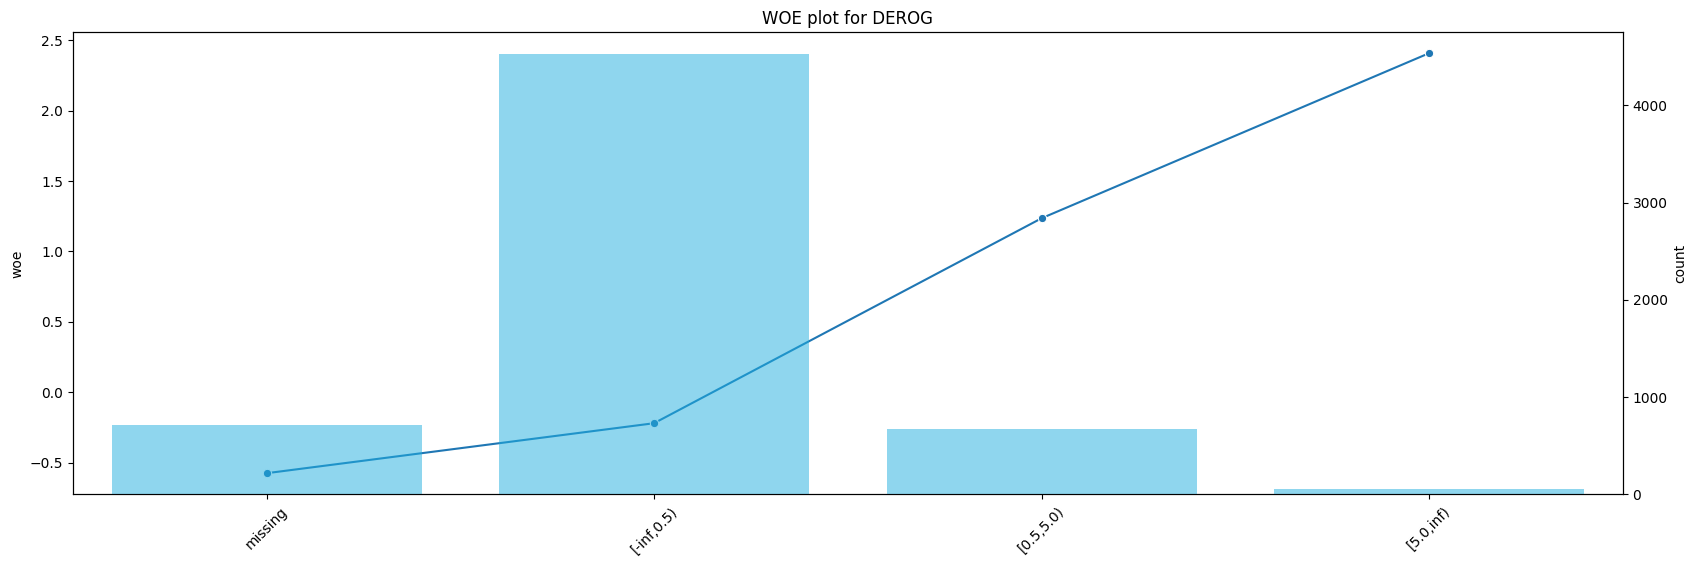

In [74]:
# your code here

breaks_adj = {'DEROG' : [0,0.5, 5]}
bins3 = sc.woebin(hmeq_data_woe, y='BAD', breaks_list=breaks_adj)
bins3['DEROG']
woe_plot(bins3['DEROG'],'DEROG')

Use scorecardpy to do the initial calculations of IV for your variables in the Group Assignment data as a starting point for variable screening.

Use scorecardpy to help do fine and coarse classing for the variables that remain after screening.